# Data Analysis
----------------------

## Library Importation

In [1]:
import sys
sys.path.append("./lib/")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lib.Methods import GeneralMethods
from lib.edasSearch import EdasHyperparameterSearch
from lib.Hiperparametros import HyperparameterSwitcher
from lib.ImportacionModelos import getClassifierNames
from lib.ImportacionModelos import getClassifierModels
from lib.ImportacionModelos import getRegressorNames
from lib.ImportacionModelos import getRegressorModels
from lib.graphicGenerator import GraphicBuilder


dfTrain = pd.read_csv("data/UJIndoorLoc_trainingData.csv")
description = pd.read_csv("data/description.csv", sep=";")
dfTest = pd.read_csv("data/UJIndoorLoc_validationData.csv")
gbTrain = GraphicBuilder(dfTrain)
gbTest = GraphicBuilder(dfTrain)

## Data Description

In [28]:
description = pd.read_csv("data/description.csv", sep=";")
display(description)

,Attribute,Definition
WAP001,Intensity value for WAP001,Negative integer values from -104 to 0 and +1...
...,...,...
WAP520,Intensity value for WAP520,Negative integer values from -104 to 0 and +1...
Longitude,Longitude,Negative real values from -7695.9387549299299...
Latitude,Latitude,Positive real values from 4864745.7450159714 ...
Floor,Altitude in floors inside the building,Integer values from 0 to 4.
BuildingID,ID to identify the building. Measures were ta...,Categorical integer values from 0 to 2.
SpaceID,Internal ID number to identify the Space (off...,Categorical integer values.
RelativePosition,Relative position with respect to the Space (...,Categorical integer values.
UserID,User identifier,Categorical integer values.


In [23]:
dfTrain.FLOOR = dfTrain.FLOOR.apply(str)
dfTrain.BUILDINGID = dfTrain.BUILDINGID.apply(str)
dfTrain.SPACEID = dfTrain.SPACEID.apply(str)
dfTrain.RELATIVEPOSITION = dfTrain.RELATIVEPOSITION.apply(str)
dfTrain.USERID = dfTrain.USERID.apply(str)
dfTrain.PHONEID = dfTrain.PHONEID.apply(str)
# Colums Data Description
display(dfTrain[dfTrain.columns.values[519:]].describe(include=['int64', 'float']))
display(dfTrain[dfTrain.columns.values[519:]].describe(include=['object']))
# Building vs Floor Distribution of Data
display(pd.crosstab(dfTrain.FLOOR, dfTrain.BUILDINGID))

,WAP520,LONGITUDE,LATITUDE,TIMESTAMP
count,19937.0,19937.000000,1.993700e+04,1.993700e+04
mean,100.0,-7464.275947,4.864871e+06,1.371421e+09
std,0.0,123.402010,6.693318e+01,5.572054e+05
min,100.0,-7691.338400,4.864746e+06,1.369909e+09
25%,100.0,-7594.737000,4.864821e+06,1.371056e+09
50%,100.0,-7423.060900,4.864852e+06,1.371716e+09
75%,100.0,-7359.193000,4.864930e+06,1.371721e+09
max,100.0,-7300.818990,4.865017e+06,1.371738e+09


,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID
count,19937,19937,19937,19937,19937,19937
unique,5,3,123,2,18,16
top,3,2,202,2,11,14
freq,5048,9492,484,16608,4516,4835


BUILDINGID,0,1,2
FLOOR,,,
0,1059,1368,1942
1,1356,1484,2162
2,1443,1396,1577
3,1391,948,2709
4,0,0,1102


## Graphic Description of Data

<IPython.core.display.Javascript object>


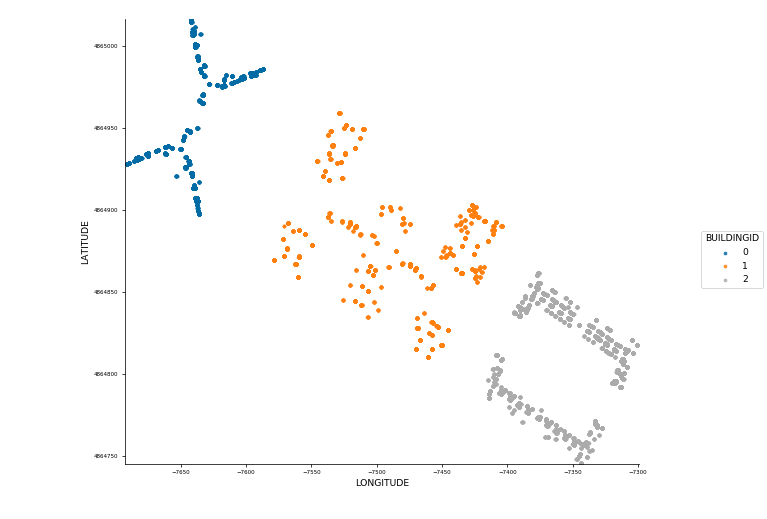

In [8]:
%matplotlib notebook
gbTrain.graphicMap2D(filename="buildingsMap2d",  x = "LONGITUDE", y="LATITUDE", hue="BUILDINGID")

<IPython.core.display.Javascript object>


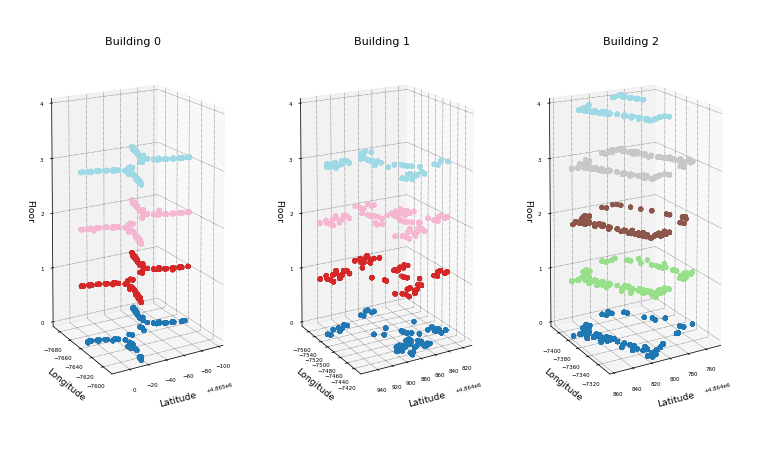

In [7]:
%matplotlib notebook
gbTrain.graphicBuildings(columns = ["LATITUDE", "LONGITUDE", "FLOOR"], filename="buildingsTrain")

<IPython.core.display.Javascript object>


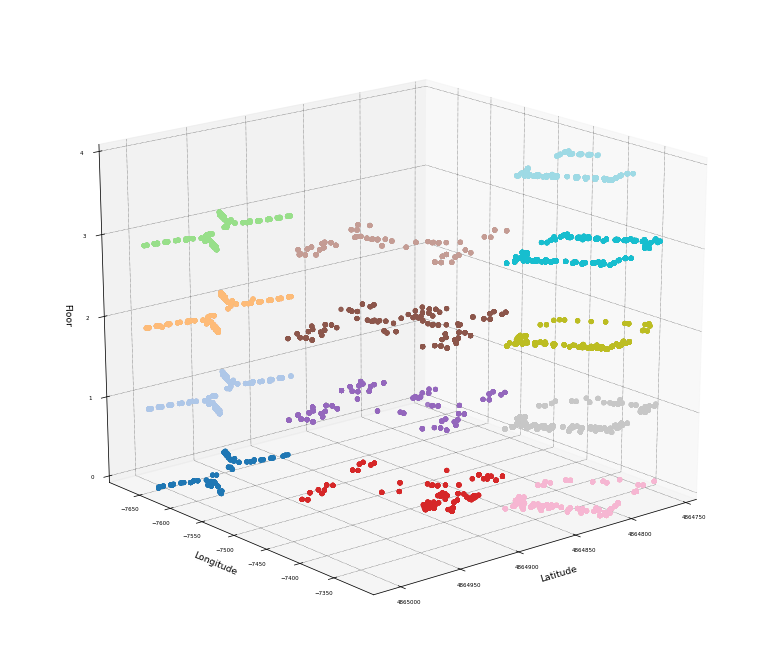

In [6]:
%matplotlib notebook
gbTrain.graphicMap3D(columns = ["LATITUDE", "LONGITUDE", "FLOOR"], filename="buildingsMap3d")

## Cleaning the Data

In [7]:
dfTrain = pd.read_csv("data/UJIndoorLoc_trainingData.csv")
display('Initial Size')
display(dfTrain.shape)


def cleanBySignificance(inputData):
    wifiSens = 520
    noDetectedValue = 100
    wifiColumns = inputData.columns.values[0:wifiSens]
    outColumns = inputData.columns.values[wifiSens:]
    dfTemp = inputData[wifiColumns]

    # drop columns (all rows in a column = 100, dont make any significance)
    wa_columns = pd.DataFrame(dfTemp.sum(axis=0) == inputData.shape[0] * noDetectedValue, columns=['isOut'])
    wa_columns = wa_columns[wa_columns.isOut == False].T.columns.values
    new_columns = list(wa_columns) + list(outColumns)
    inputData = inputData[new_columns]

    # drop rows (all columns = 100 with different spaceId, buildingId, floorId)
    inputData = inputData[dfTemp.sum(axis=1)  != wifiSens * noDetectedValue]
    return inputData, new_columns

dfTrain, columnFilter = cleanBySignificance(dfTrain)
display('New Size')
display(dfTrain.shape)

'Initial Size'

(19937, 529)

'New Size'

(19861, 474)

In [ ]:
dfTemp = dfTrain[['LONGITUDE', 'LATITUDE']]
dfTemp['minLong'] = np.min(dfTrain.LONGITUDE)
dfTemp['meanLong'] = np.mean(dfTrain.LONGITUDE)
dfTemp['minLat'] = np.min(dfTrain.LATITUDE)
dfTemp['meanLat'] = np.mean(dfTrain.LATITUDE)
import geopy.distance
dfTrain['LONGITUDE_M'] = geopy.distance.vincenty((dfTemp.meanLat, dfTemp.LONGITUDE), (dfTemp.meanLat, dfTemp.minLong)).m
dfTrain['LATITUDE_M'] = geopy.distance.vincenty((dfTemp.LATITUDE, dfTemp.meanLong), (dfTemp.minLat, dfTemp.meanLong)).m

# lsd = (dfTemp.LATITUDE, dfTemp.LONGITUDE)
#geopy.distance.vincenty((x.meanLat, x.LONGITUDE), (x.meanLat, x.minLong)).m
lsd = dfTemp.apply(lambda x: ((x.meanLat, x.LONGITUDE), (x.meanLat, x.minLong)), axis=1)
lsd

#dfTemp['LONGITUDE'] + dfTemp['LATITUDE']
#-7480.124099999665
geopy.distance.vincenty((4.864746e6, -7536.6211999990055), (4.864746e6, -7300.8189909990055))

4864870.934704428/(39.9929396083499)#60*60*1000)
121643.24459132078/(90*3600)

## Mixed Prediction

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

seed = 7
wifiSens = 520
xTrain = dfTrain[dfTrain.columns.values[0:wifiSens]]
# xTrain = dfTrain #[list(wa_columns)]
xTest = dfTest[dfTest.columns.values[0:wifiSens]]
#xTest = dfTest #[list(wa_columns)]

model = RandomForestClassifier(n_jobs=-1, random_state=seed)
model.fit(xTrain, dfTrain.FLOOR)
p_floor = model.predict(xTest)
display('Floor Classification Score')
display(model.score(xTest, dfTest.FLOOR))

model = RandomForestClassifier(n_jobs=-1, random_state=seed)
model.fit(xTrain, dfTrain.BUILDINGID)
p_building = model.predict(xTest)
display('Building Classification Score')
display(model.score(xTest, dfTest.BUILDINGID))

model = RandomForestRegressor(n_jobs=-1, random_state=seed)
model.fit(xTrain, dfTrain.LATITUDE)
p_latitude = model.predict(xTest)
display('Latitude Regression Score')
display(model.score(xTest, dfTest.LATITUDE))

model = RandomForestRegressor(n_jobs=-1, random_state=seed)
model.fit(xTrain, dfTrain.LONGITUDE)
p_longitude = model.predict(xTest)
display('Longitude Regression Score')
display(model.score(xTest, dfTest.LONGITUDE))

# setting predicted values into dataframe
dfTest['PRED_FLOOR'] = p_floor
dfTest['PRED_BUILDING'] = p_building
dfTest['PRED_LATITUDE'] = p_latitude
dfTest['PRED_LONGITUDE'] = p_longitude

'Floor Classification Score'

0.8046804680468047

'Building Classification Score'

0.9981998199819982

'Latitude Regression Score'

0.9626092899099439

'Longitude Regression Score'

0.9833886078390593

<IPython.core.display.Javascript object>


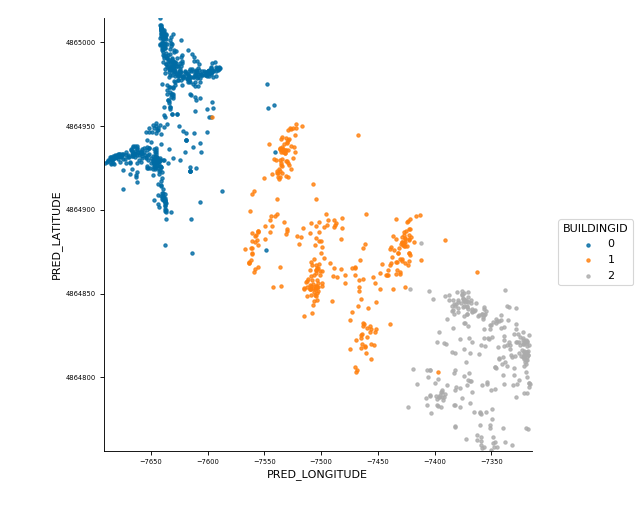

In [17]:
graphicMap2D(dfTest, filename="predicted2d", x = "PRED_LONGITUDE", y="PRED_LATITUDE", hue="BUILDINGID")

<IPython.core.display.Javascript object>


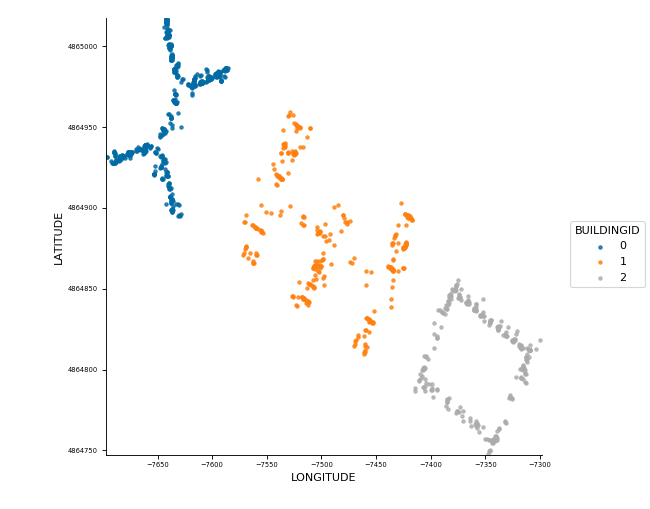

In [16]:
graphicMap2D(dfTest, filename="validated2d", x = "LONGITUDE", y="LATITUDE", hue="BUILDINGID")

<IPython.core.display.Javascript object>


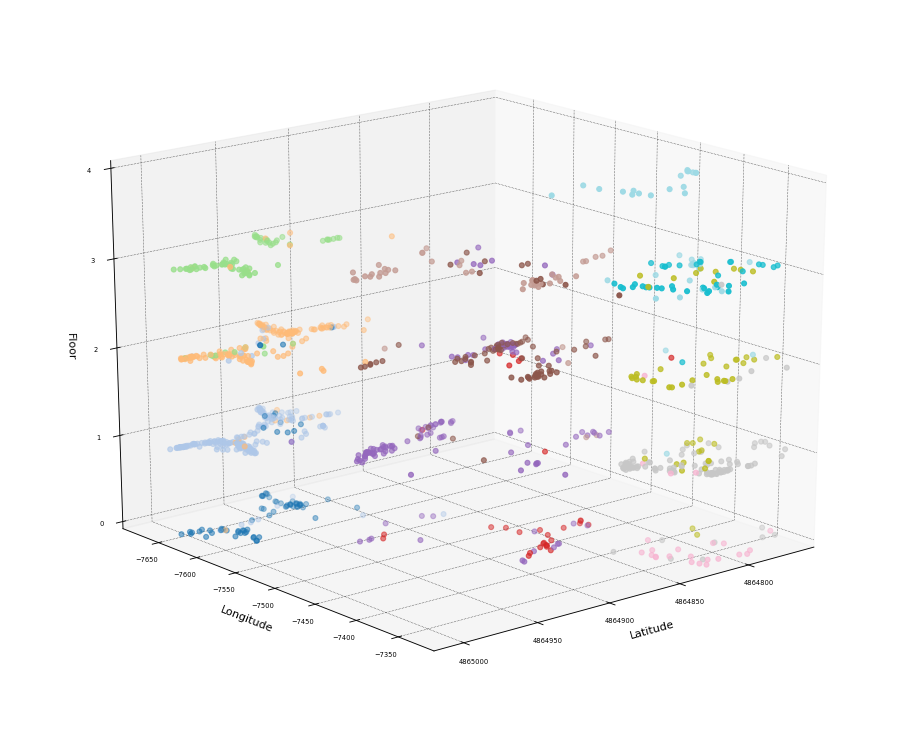

In [18]:
graphicMap3D(dfTest, columns = ["PRED_LATITUDE", "PRED_LONGITUDE", "PRED_FLOOR"], filename="predictedBuildingsMap3d")

<IPython.core.display.Javascript object>


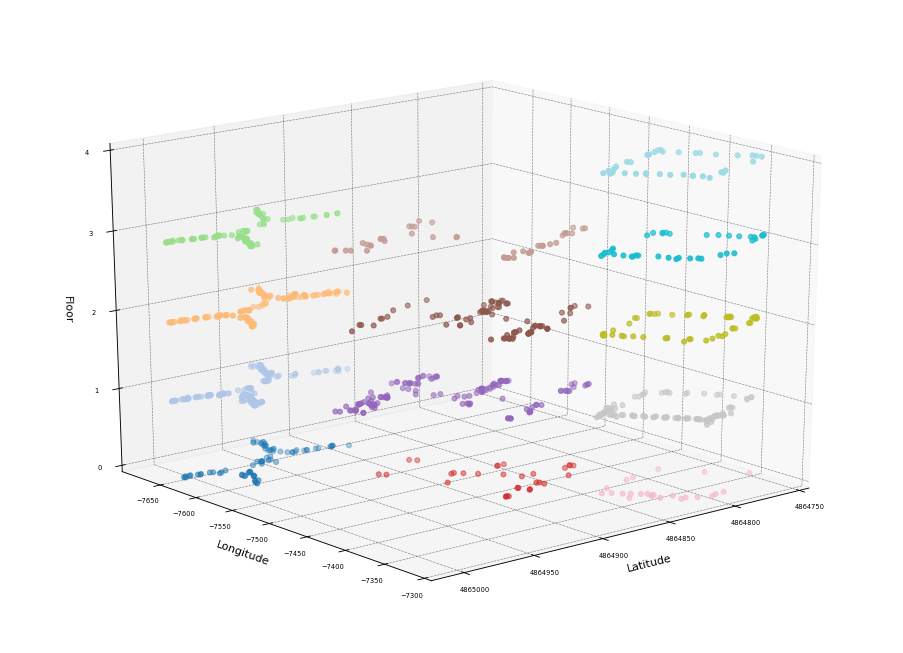

In [19]:
graphicMap3D(dfTest, columns = ["LATITUDE", "LONGITUDE", "FLOOR"], filename="realBuildingsMap3d")